In [1]:
# Data reading 
import pandas as pd 

# Array math 
import numpy as np

# Random number generation
import random

# Dates 
import datetime

# Ploting 
import matplotlib.pyplot as plt 
import seaborn as sns

# Deep learning
from tensorflow import keras
from NNmodel import NNMultistepModel

In [2]:
# Downloading data 
dl_data = False

if dl_data:
    !python3 dataDownload.py

In [3]:
# Creating tidy data
!python3 createTidyData.py

In [4]:
def create_X_Y_generalized(ts: np.array, n_features: int, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Wrangling LT data

In [73]:
d = pd.read_csv('data/tidy_data_LT.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the data since the second wave
d = d[d['day']>= datetime.datetime(2020, 8, 1).date()]

# Leaving only the time series 
dLT = d[['is_hospitalized', 'is_covid']]

# Saving the days list 
days = d.day

# Calculating the rolling mean for Lithuania data 
dLTmean = dLT.rolling(window=7).mean()

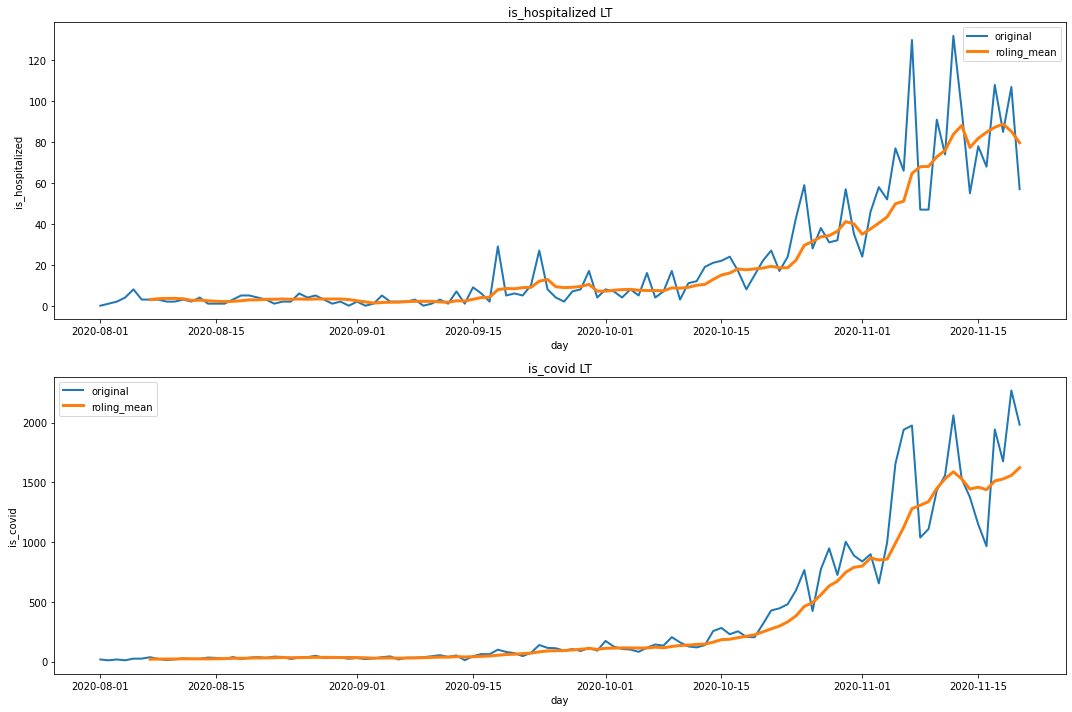

In [6]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = dLT.columns

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=d['day'], y=dLT[feature], linewidth=2, label='original')
    sns.lineplot(ax=axes[i], x=d['day'], y=dLTmean[feature], linewidth=3, label='roling_mean')
    axes[i].set_title(f'{feature} LT')
        
plt.tight_layout()

# Wrangling US data 

In [7]:
d = pd.read_csv('data/tidy_data_US.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the data since the second wave
d = d[d['day']>= datetime.datetime(2020, 8, 1).date()]

# Droping the day column 
d.drop('day', inplace=True, axis=1)

# Getting the list of unique states 
states = [x[-2:] for x in d.columns]
states = list(set(states))

# Creating a data dictionary 
dstates = {}

for state in states:
    if len(set([f'is_hospitalized_{state}', f'is_covid_{state}']).intersection(d.columns)) == 2:
        stateInfo = d[[f'is_hospitalized_{state}', f'is_covid_{state}']].copy()
        stateInfo.rename(columns={
            f'is_hospitalized_{state}': 'is_hospitalized',
            f'is_covid_{state}': 'is_covid'
        }, inplace=True)
        
        dstates.update({state: stateInfo})
        
# Final state list used in analysis
states = list(dstates.keys())

In [8]:
dUS = pd.read_csv('data/tidy_data_US.csv')

# Sorting by date 
dUS['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in dUS['day']]
dUS.sort_values('day', inplace=True)

# Leaving only the data since the second wave
dUS = dUS[dUS['day']>= datetime.datetime(2020, 8, 1).date()]

# Droping the date column
dUS = dUS.drop('day', axis=1)

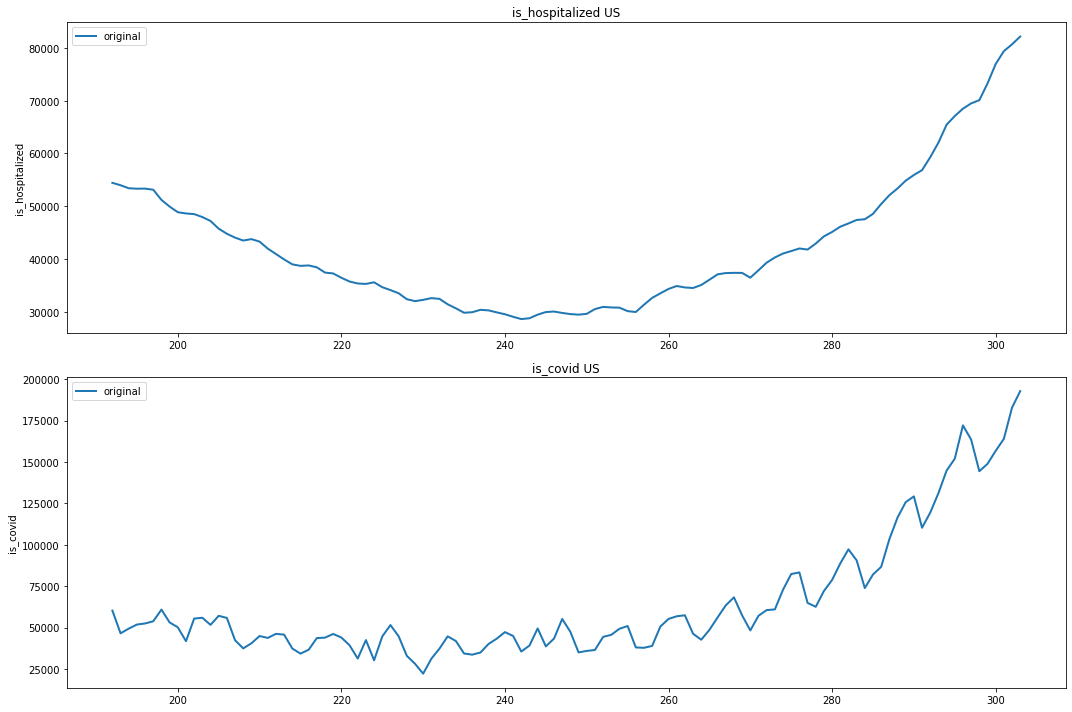

In [9]:
# Ploting some states
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = dUS.columns

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=dUS.index, y=dUS[feature], linewidth=2, label='original')
    axes[i].set_title(f'{feature} US')
        
plt.tight_layout()

# Calculating percentage changes in all the datasets

In [10]:
# US dataset
#dstates_pct = {}
#for state in states:
    #stateInfo = dstates.get(state)
    #stateInfo = stateInfo.pct_change() 
    #stateInfo = stateInfo.replace([np.inf, -np.inf], np.nan)
    #stateInfo.fillna(0, inplace=True)
    
    #dstates_pct.update({state: stateInfo})

dUS_pct = dUS.pct_change()
dUS_pct = dUS_pct.replace([np.inf, -np.inf], np.nan)
dUS_pct.fillna(0, inplace=True)    
    
# Dataset for Lithuania
dLT_pct = dLT.pct_change()
dLT_pct = dLT_pct.replace([np.inf, -np.inf], np.nan)
dLT_pct.fillna(0, inplace=True)

# Creating the dataframes for training 

In [11]:
# Setting the hyper parameters 
# Defining the lag 
n_lag = 30

# Defining the steps ahead to forecast 
n_ahead = 7

# Number of features used in the model 
n_ft = dLT.shape[1]

In [12]:
#X, Y = [], []

# US data 

#for i, state in enumerate(states):
    #stateInfo = dstates_pct.get(state)
    #stateInfo = stateInfo.values
    #Xstate, Ystate = create_X_Y_generalized(stateInfo, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)
    
    #if i == 0:
        #X = Xstate
        #Y = Ystate
    #else:
        # Appending to the master arrays
        #X = np.concatenate([X, Xstate])
        #Y = np.concatenate([Y, Ystate])

# LT data 
#Xlt, Ylt = create_X_Y_generalized(dLT_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)

#X, Y = [], []

#X = np.concatenate([X, Xlt])
#Y = np.concatenate([Y, Ylt])

In [13]:
Xus, Yus = create_X_Y_generalized(dUS_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)
Xlt, Ylt = create_X_Y_generalized(dLT_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)

X = np.concatenate([Xus, Xlt])
Y = np.concatenate([Yus, Ylt])

In [14]:
# Defining the number of last n_ahead obs to keep in the validation set
n_val = 1

# All indexes 
ind = list(range(len(X)))

# Getting the indexes for training 
train_idx = ind[:-n_val]

# Getting the indexes for validation 
val_idx = list(set(ind) - set(train_idx))

# Extracting train and validation matrices for deep learning training
Xtrain, Ytrain = X[train_idx], Y[train_idx]
Xval, Yval = X[val_idx], Y[val_idx]

print(f"Shape of the training feature matrix (series): {Xtrain.shape}")
print(f"Shape of the validation feature matrix (series): {Xval.shape}")
print(f"Shape of the target matrix: {Ytrain.shape}")
print(f"Shape of the validation target matrix: {Yval.shape}")

Shape of the training feature matrix (series): (149, 30, 2)
Shape of the validation feature matrix (series): (1, 30, 2)
Shape of the target matrix: (149, 7)
Shape of the validation target matrix: (1, 7)


In [15]:
# Creating the model object for validation 
modelVal = NNMultistepModel(
    X=Xtrain, 
    Y=Ytrain, 
    n_lag=n_lag, 
    n_ft=n_ft,
    n_outputs=n_ahead,
    Xval=Xval,
    Yval=Yval
)

In [16]:
print(f'Number of epochs: {modelVal.epochs}')
print(f'Number of neurons in LSMT layer {modelVal.n_layer}')
print(f'Learning rate: {modelVal.lr}')

Number of epochs: 600
Number of neurons in LSMT layer 64
Learning rate: 0.0001


In [17]:
modelVal.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 2)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                17152     
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
Total params: 17,607
Trainable params: 17,607
Non-trainable params: 0
_________________________________________________________________


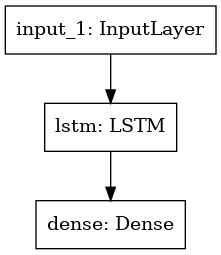

In [18]:
keras.utils.plot_model(modelVal.model)

In [19]:
history = modelVal.train()

Epoch 1/600
19/19 [==============================] - 0s 19ms/step - loss: 0.5042 - val_loss: 0.3292
Epoch 2/600
19/19 [==============================] - 0s 8ms/step - loss: 0.5029 - val_loss: 0.3285
Epoch 3/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5021 - val_loss: 0.3280
Epoch 4/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5016 - val_loss: 0.3280
Epoch 5/600
19/19 [==============================] - 0s 8ms/step - loss: 0.5012 - val_loss: 0.3283
Epoch 6/600
19/19 [==============================] - 0s 8ms/step - loss: 0.5009 - val_loss: 0.3285
Epoch 7/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5007 - val_loss: 0.3287
Epoch 8/600
19/19 [==============================] - 0s 8ms/step - loss: 0.5005 - val_loss: 0.3289
Epoch 9/600
19/19 [==============================] - 0s 8ms/step - loss: 0.5003 - val_loss: 0.3289
Epoch 10/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5002 - val_loss: 0.3288
Epoch 11

Epoch 83/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4864 - val_loss: 0.3077
Epoch 84/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4856 - val_loss: 0.3078
Epoch 85/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4860 - val_loss: 0.3053
Epoch 86/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4868 - val_loss: 0.3073
Epoch 87/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4855 - val_loss: 0.3096
Epoch 88/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4847 - val_loss: 0.3080
Epoch 89/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4856 - val_loss: 0.3045
Epoch 90/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4872 - val_loss: 0.3062
Epoch 91/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4862 - val_loss: 0.3095
Epoch 92/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4853 - val_loss: 0.3093


19/19 [==============================] - 0s 7ms/step - loss: 0.4831 - val_loss: 0.3048
Epoch 165/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4826 - val_loss: 0.3052
Epoch 166/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4821 - val_loss: 0.3048
Epoch 167/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4816 - val_loss: 0.3050
Epoch 168/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4811 - val_loss: 0.3049
Epoch 169/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4806 - val_loss: 0.3046
Epoch 170/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4802 - val_loss: 0.3039
Epoch 171/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4797 - val_loss: 0.3041
Epoch 172/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4793 - val_loss: 0.3023
Epoch 173/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4787 - val_loss: 0.3014
Epoc

19/19 [==============================] - 0s 8ms/step - loss: 0.4700 - val_loss: 0.2997
Epoch 246/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4715 - val_loss: 0.2970
Epoch 247/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4669 - val_loss: 0.2955
Epoch 248/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4685 - val_loss: 0.2956
Epoch 249/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4709 - val_loss: 0.2983
Epoch 250/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4738 - val_loss: 0.2965
Epoch 251/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4689 - val_loss: 0.2939
Epoch 252/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4710 - val_loss: 0.2982
Epoch 253/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4805 - val_loss: 0.3007
Epoch 254/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4807 - val_loss: 0.3007
Epoc

19/19 [==============================] - 0s 7ms/step - loss: 0.4603 - val_loss: 0.2911
Epoch 327/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4576 - val_loss: 0.2881
Epoch 328/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4654 - val_loss: 0.2984
Epoch 329/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4770 - val_loss: 0.3027
Epoch 330/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4759 - val_loss: 0.2990
Epoch 331/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4731 - val_loss: 0.2955
Epoch 332/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4692 - val_loss: 0.2922
Epoch 333/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4640 - val_loss: 0.2890
Epoch 334/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4585 - val_loss: 0.2880
Epoch 335/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4606 - val_loss: 0.2895
Epoc

19/19 [==============================] - 0s 8ms/step - loss: 0.4598 - val_loss: 0.2881
Epoch 408/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4538 - val_loss: 0.2876
Epoch 409/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4481 - val_loss: 0.2872
Epoch 410/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4533 - val_loss: 0.2851
Epoch 411/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4498 - val_loss: 0.2912
Epoch 412/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4657 - val_loss: 0.2926
Epoch 413/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4600 - val_loss: 0.2859
Epoch 414/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4516 - val_loss: 0.2839
Epoch 415/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4511 - val_loss: 0.2861
Epoch 416/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4583 - val_loss: 0.2878
Epoc

19/19 [==============================] - 0s 8ms/step - loss: 0.4419 - val_loss: 0.2890
Epoch 489/600
19/19 [==============================] - 0s 8ms/step - loss: 0.4467 - val_loss: 0.2886
Epoch 490/600
19/19 [==============================] - 0s 8ms/step - loss: 0.4470 - val_loss: 0.2870
Epoch 491/600
19/19 [==============================] - 0s 8ms/step - loss: 0.4486 - val_loss: 0.2914
Epoch 492/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4699 - val_loss: 0.2933
Epoch 493/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4698 - val_loss: 0.2921
Epoch 494/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4674 - val_loss: 0.2910
Epoch 495/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4640 - val_loss: 0.2895
Epoch 496/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4585 - val_loss: 0.2875
Epoch 497/600
19/19 [==============================] - 0s 8ms/step - loss: 0.4495 - val_loss: 0.2842
Epoc

19/19 [==============================] - 0s 7ms/step - loss: 0.4384 - val_loss: 0.2829
Epoch 570/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4369 - val_loss: 0.2844
Epoch 571/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4479 - val_loss: 0.2820
Epoch 572/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4349 - val_loss: 0.2857
Epoch 573/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4380 - val_loss: 0.2843
Epoch 574/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4414 - val_loss: 0.2843
Epoch 575/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4345 - val_loss: 0.2846
Epoch 576/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4360 - val_loss: 0.2889
Epoch 577/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4511 - val_loss: 0.2861
Epoch 578/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4376 - val_loss: 0.2804
Epoc

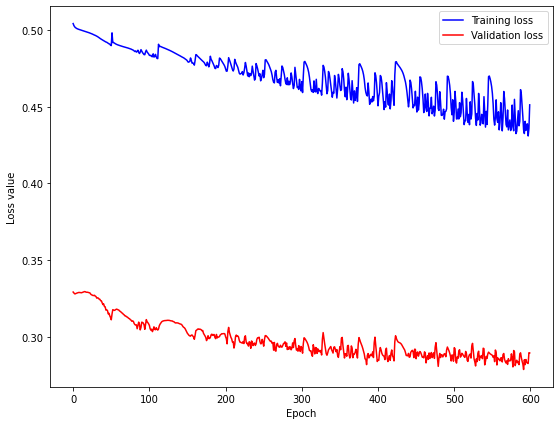

In [20]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [27]:
yhatval_abs = [x for x in modelVal.predict(Xval)][0]
yval_abs = [x for x in Yval][0]

fc = pd.concat([
    pd.DataFrame({'value': yval_abs, 'index': range(len(yval_abs)), 'type': 'original'}),
    pd.DataFrame({'value': yhatval_abs, 'index': range(len(yval_abs)), 'type': 'forecast'})
], axis=0)

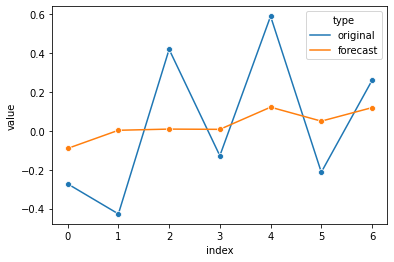

In [29]:
sns.lineplot(x='index', y='value', data=fc, hue='type', marker='o')
plt.show()

In [31]:
day_avg_real = np.mean(yval_abs)
day_avg_forecast = np.mean(yhatval_abs)

print(f"7 day average real: {day_avg_real * 100}%")
print(f"7 day average forecasted: {day_avg_forecast * 100}%")

7 day average real: 3.203742064036181%
7 day average forecasted: 3.1036870554089546%


In [50]:
# Building the final model and forecasting
modelFinal = NNMultistepModel(
    X=X, 
    Y=Y, 
    n_lag=n_lag, 
    n_ft=n_ft,
    n_outputs=n_ahead
)

history = modelFinal.train()

Epoch 1/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5049
Epoch 2/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5035
Epoch 3/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5025
Epoch 4/600
19/19 [==============================] - 0s 6ms/step - loss: 0.5019
Epoch 5/600
19/19 [==============================] - 0s 7ms/step - loss: 0.5014
Epoch 6/600
19/19 [==============================] - 0s 6ms/step - loss: 0.5009
Epoch 7/600
19/19 [==============================] - 0s 6ms/step - loss: 0.5005
Epoch 8/600
19/19 [==============================] - 0s 6ms/step - loss: 0.5002
Epoch 9/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4998
Epoch 10/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4995
Epoch 11/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4993
Epoch 12/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4990
Epoch 13/600
19/19 [=================

19/19 [==============================] - 0s 5ms/step - loss: 0.4837
Epoch 103/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4836
Epoch 104/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4834
Epoch 105/600
19/19 [==============================] - 0s 8ms/step - loss: 0.4832
Epoch 106/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4830
Epoch 107/600
19/19 [==============================] - 0s 8ms/step - loss: 0.4828
Epoch 108/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4824
Epoch 109/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4820
Epoch 110/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4816
Epoch 111/600
19/19 [==============================] - 0s 8ms/step - loss: 0.4810
Epoch 112/600
19/19 [==============================] - 0s 7ms/step - loss: 0.4804
Epoch 113/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4800
Epoch 114/600
19/19 [=========

19/19 [==============================] - 0s 6ms/step - loss: 0.4675
Epoch 203/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4691
Epoch 204/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4685
Epoch 205/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4732
Epoch 206/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4707
Epoch 207/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4674
Epoch 208/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4674
Epoch 209/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4708
Epoch 210/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4673
Epoch 211/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4660
Epoch 212/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4685
Epoch 213/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4655
Epoch 214/600
19/19 [=========

19/19 [==============================] - 0s 8ms/step - loss: 0.4531
Epoch 303/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4613
Epoch 304/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4542
Epoch 305/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4583
Epoch 306/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4752
Epoch 307/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4751
Epoch 308/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4736
Epoch 309/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4717
Epoch 310/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4692
Epoch 311/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4652
Epoch 312/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4592
Epoch 313/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4524
Epoch 314/600
19/19 [=========

19/19 [==============================] - 0s 5ms/step - loss: 0.4608
Epoch 403/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4505
Epoch 404/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4505
Epoch 405/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4683
Epoch 406/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4676
Epoch 407/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4644
Epoch 408/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4603
Epoch 409/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4549
Epoch 410/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4469
Epoch 411/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4449
Epoch 412/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4521
Epoch 413/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4433
Epoch 414/600
19/19 [=========

19/19 [==============================] - 0s 6ms/step - loss: 0.4439
Epoch 503/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4352
Epoch 504/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4386
Epoch 505/600
19/19 [==============================] - 0s 6ms/step - loss: 0.4529
Epoch 506/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4463
Epoch 507/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4354
Epoch 508/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4385
Epoch 509/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4568
Epoch 510/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4495
Epoch 511/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4367
Epoch 512/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4463
Epoch 513/600
19/19 [==============================] - 0s 5ms/step - loss: 0.4569
Epoch 514/600
19/19 [=========

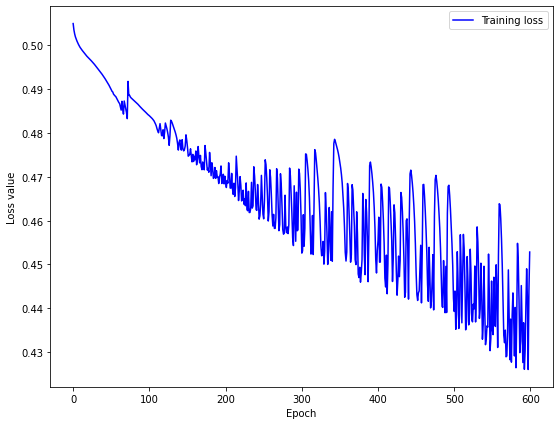

In [51]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [89]:
xNewest = dLT_pct[-n_lag:]
xNewest = xNewest.values
xNewest = np.reshape(xNewest, (1, n_lag, n_ft))

forecast = modelFinal.predict(xNewest)

In [79]:
print(dLT.tail(n_lag))

     is_hospitalized  is_covid
226               17       445
227               24       480
228               43       596
229               59       765
230               28       422
231               38       772
232               31       947
233               32       724
234               57      1002
235               35       886
236               24       837
237               46       898
238               58       654
239               52       995
240               77      1654
241               66      1940
242              130      1975
243               47      1037
244               47      1109
245               91      1432
246               74      1559
247              132      2060
248               96      1530
249               55      1374
250               78      1148
251               68       965
252              108      1942
253               85      1675
254              107      2268
255               57      1982


In [90]:
print(f"Next 7 days will grow at an average {np.mean(forecast) * 100} %")

Next 7 days will grow at an average 3.012991137802601 %


In [91]:
base = days.tail(1).values[0]
date_list = [base + datetime.timedelta(days=x) for x in range(n_ahead)]
date_list = [x + datetime.timedelta(days=1) for x in date_list]

In [103]:
fc = pd.DataFrame({'day': date_list, 'forecast_pct_change': [x * 100 for x in forecast[0]]})

In [105]:
print(fc)

          day  forecast_pct_change
0  2020-11-21             5.939732
1  2020-11-22            -1.419941
2  2020-11-23             4.566869
3  2020-11-24             2.647212
4  2020-11-25             2.473433
5  2020-11-26            10.915177
6  2020-11-27            -4.031543


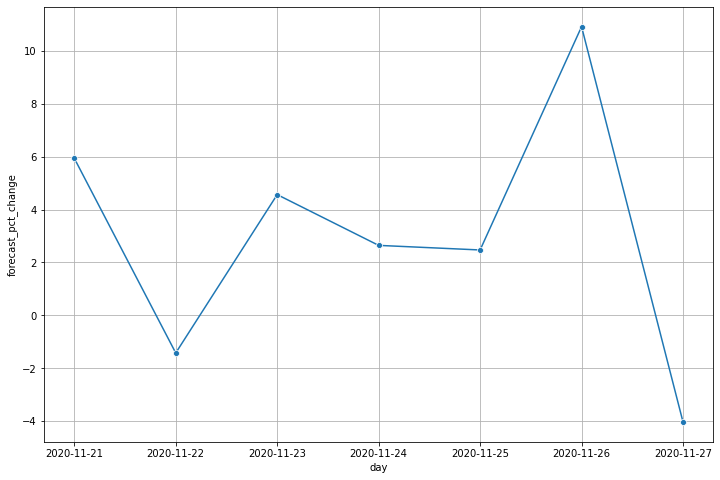

In [104]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='day', y='forecast_pct_change', data=fc, marker='o')
plt.grid()
plt.show()